In [50]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
from tqdm.auto import tqdm

%matplotlib inline

In [53]:
def plot_P(func, P):
    fig, ax = plt.subplots(1, 2, figsize = (17, 5))
    fig.suptitle(f"{func}. Best score: {np.max(P[1])}")
    T = len(P[1])
    ax[0].plot(np.arange(T), P[1], label = 'Best')
    ax[0].plot(np.arange(T), P[2], label = 'Worst')
    ax[0].plot(np.arange(T), P[3], label = 'Mean')
    ax[0].legend(loc = 'lower right')
    ax[0].set_title('Objective function value')
    
    ax[1].plot(np.arange(T), np.array(P[4]))
    ax[1].set_title('Probabilities')
    plt.show()

In [6]:
def  initial_probability_vector():
    p = np.array([0.5 for _ in np.arange(0, d)])
    return p

In [7]:
def binary_random(p):
    return int(np.random.rand() < p)

In [8]:
def random_individual(p):
    x = np.array([binary_random(p[i]) for i in np.arange(d)])
    return x

In [9]:
def random_population(p, N):
    P = np.array([random_individual(p) for _ in np.arange(N)])
    return P

In [10]:
def one_max(P):
    return np.sum(P, 1)

In [11]:
def dec_one_max(P):
    pop_size = len(P)
    res = np.zeros(pop_size)
    for i in range(pop_size):
        if np.count_nonzero(P[i]) > 0:
            res[i] = np.sum(P[i])
        else:
            res[i] = d + 1
    return res

In [12]:
def five_dec_one_max(P):
    pop_size = len(P)
    res = np.zeros(pop_size)
    for i in range(pop_size):
        for segment in range(1, int(d/5) + 1):
            if np.count_nonzero(P[i][segment*5 - 5:segment*5]) > 0:
                res[i] += np.sum(P[i][segment*5 - 5:segment*5])
            else:
                res[i] += 6
    return res

In [13]:
def describe(P, fun):
    '''
    Returns:
    (indice of max element in fun(P), mean of fun(P), min of fun(P))
    '''
    evaluated = fun(P)
    return np.argmax(evaluated), np.mean(evaluated), np.min(evaluated)

In [62]:
class MIMIC:
    def __init__(self, T, N, obj_fun, percentile, _d):
        global d
        d = _d
        self.d = _d
        self.T, self.N, self.obj_fun, self.percentile = T, N, obj_fun, percentile
        self.p = initial_probability_vector()
        self.P = random_population(self.p, self.N)
        self.eval_P = obj_fun(self.P) * -1
        self.theta = np.median(self.eval_P)
        self.sample = self.P[[individual_value <= self.theta for individual_value in self.eval_P]]
        
    def entropy(self, X):
        '''
        Calculates entropy of X
        '''
        p_one = np.count_nonzero(X) / (len(X) + 1e-100)
        p_zero = 1 - p_one
        return -(p_one * np.log2(p_one + 1e-100) + p_zero * np.log2(p_zero + 1e-100))
    
    def cond_entropy(self, Y, X):
        '''
        Calculates conditional entropy of (X|Y)
        '''
        p_one = np.count_nonzero(X) / (len(X) + 1e-100)
        p_zero = 1 - p_one
        
        res = (p_one * self.entropy(Y[np.argwhere(X == 1).ravel()]) + 
               p_zero * self.entropy(Y[np.argwhere(X == 0).ravel()]))
        return res
      
    def update_p(self):
        # 1. i_n = arg min_j entropy(X_j)
        I = np.zeros(self.d, dtype = int)
        I[self.d-1] = (np.argmin([self.entropy(self.sample[:, k]) for k in range(self.d)]))
        
        # 2. i_k = arg min_j entropy(X_j, X_{i_k+1}), where
        # j != i_k+1, ..., i_n and k = n - 1, n - 2, ... , 2, 1
        for i in np.arange(self.d - 2, -1, -1):
            js = list(set(range(self.d)) - set(I[i+1:]))
            best_j_indice = np.argmin([self.cond_entropy(self.sample[:, j], 
                                                         self.sample[:, I[i+1]]) for j in js])
            I[i] = js[best_j_indice]
        
        self.p[I[-1]] = self.get_prob(self.sample[:, I[-1]])
        for i in range(self.d - 2):
            self.p[I[i]] = self.get_prob(self.sample[:, I[i]], self.sample[:, I[i+1]])
      
    
    def get_prob(self, X, Y = None):
        if Y is None:
            return np.count_nonzero(X) / len(X)
        else: 
            return (np.logical_and(X, Y).astype(int).sum()) / (np.count_nonzero(Y) + 1e-100)
    
    def run(self, verbose = False):
        self.best_individuals = []
        self.best_vals = np.zeros(self.T)
        self.worst_vals = np.zeros(self.T)
        self.mean_vals = np.zeros(self.T)
        self.probs = []
        for i in range(self.T):
            self.probs.append(self.p.copy())
            # Update parameters of p from a sample.
            self.update_p()
            # Generate a new population using updated p and evaluate it.
            self.P = random_population(self.p, self.N)
            self.eval_P = self.obj_fun(self.P) * -1
            # Set theta to k-th percentile of the new population. Retain only the points less than the theta.
            self.theta = np.percentile(self.eval_P, self.percentile)
            self.sample = self.P[[individual_value <= self.theta for individual_value in self.eval_P]]
            
            self.best_individuals.append(self.P[np.argmin(self.eval_P)])
            self.best_vals[i] = (np.min(self.eval_P))
            self.worst_vals[i] = (np.max(self.eval_P))
            self.mean_vals[i] = (np.mean(self.eval_P))
            if verbose and (i == 0 or i == self.T - 1 or i % 50 == 0):
                print(self.best_vals[i], min(self.best_vals))
        return self.best_individuals[np.argmax(self.best_vals)], self.best_vals*-1, self.worst_vals*-1, self.mean_vals*-1, self.probs

In [57]:
def test_mimic(T, N, percentile, _d):
    m = MIMIC(T, N, obj_fun = one_max, percentile = percentile, _d = _d)
    m = m.run()
    plot_P("one_max", m)
    m = MIMIC(T, N, obj_fun = dec_one_max, percentile = percentile, _d = _d)
    m = m.run()
    plot_P("dec_one_max", m)
    m = MIMIC(T, N, obj_fun = five_dec_one_max, percentile = percentile, _d = _d)
    m = m.run()
    plot_P("five_dec_one_max", m)

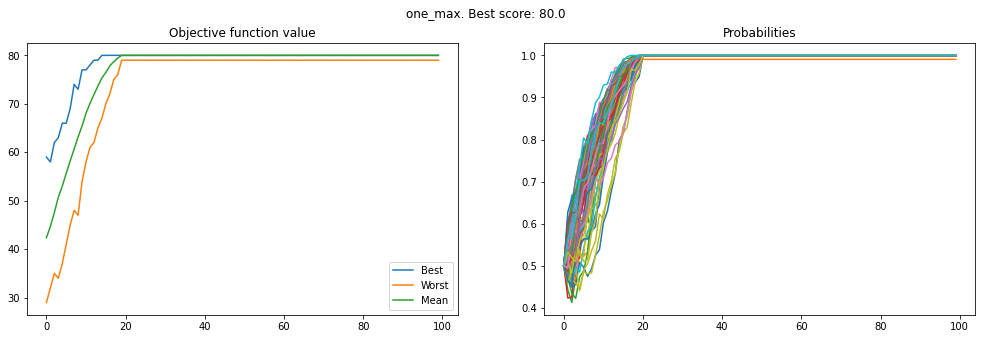

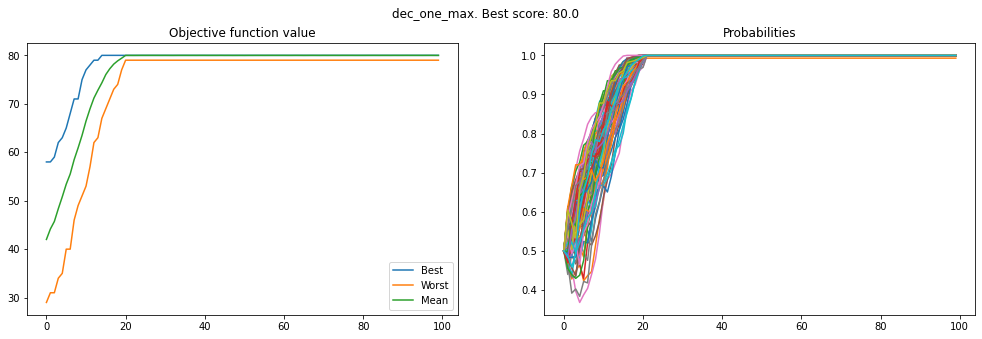

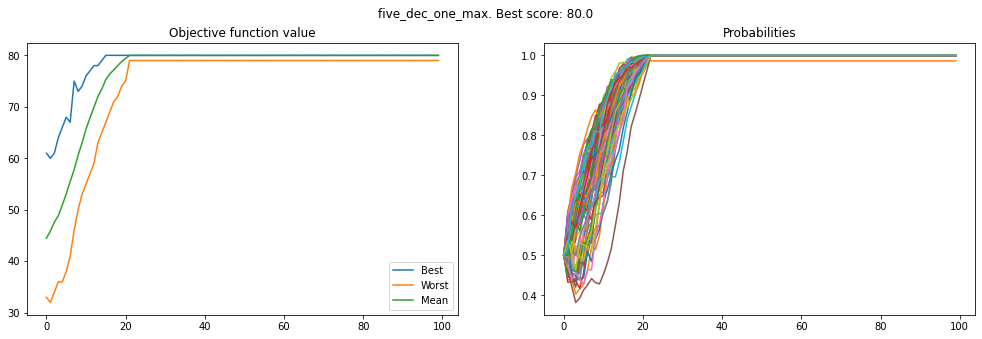

In [64]:
test_mimic(100, 1000, 50, _d = 80)

PERCENTILE = 10


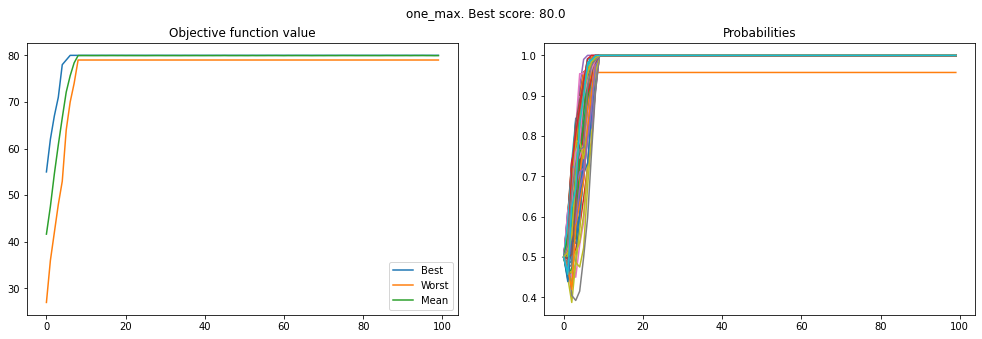

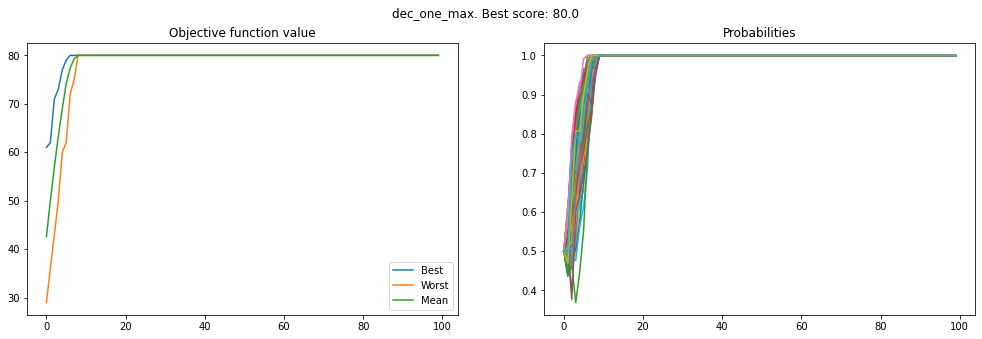

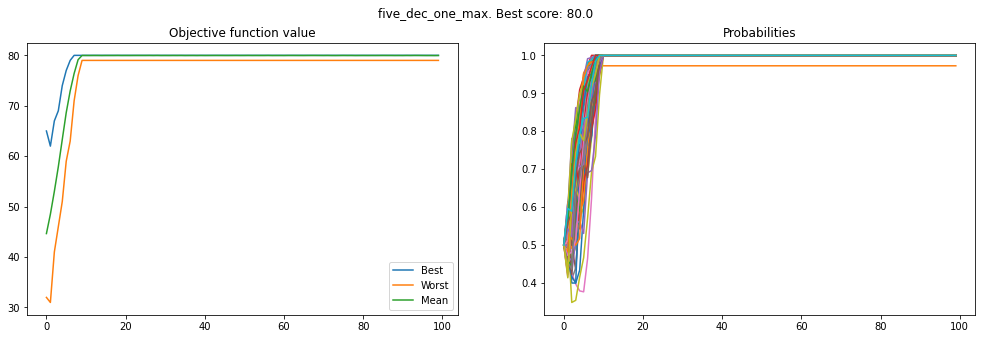

PERCENTILE = 20


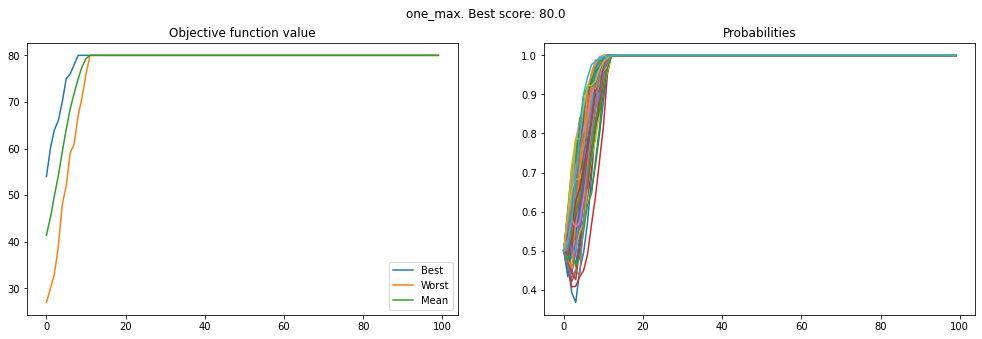

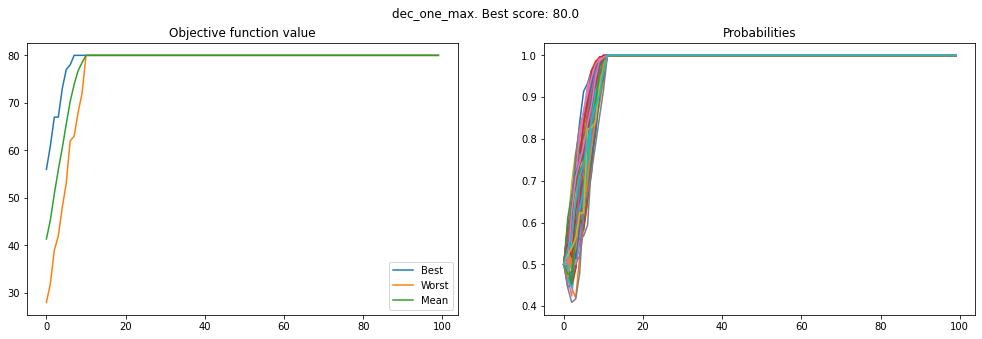

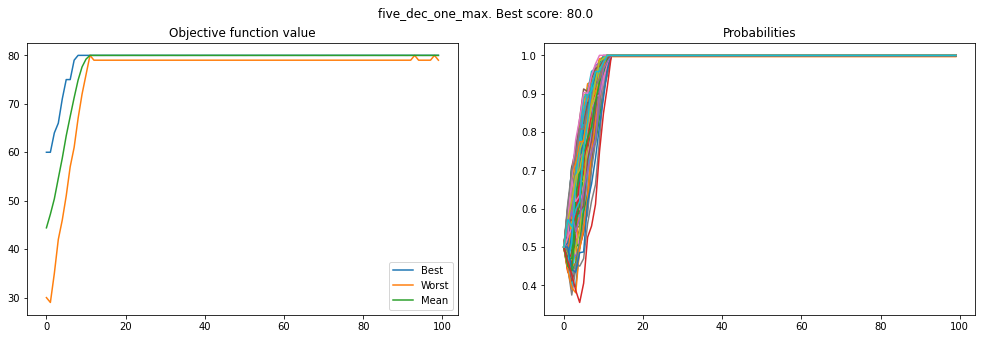

PERCENTILE = 30


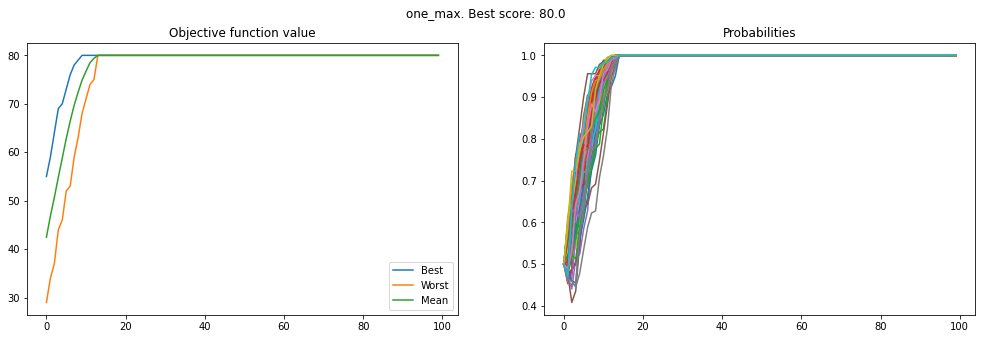

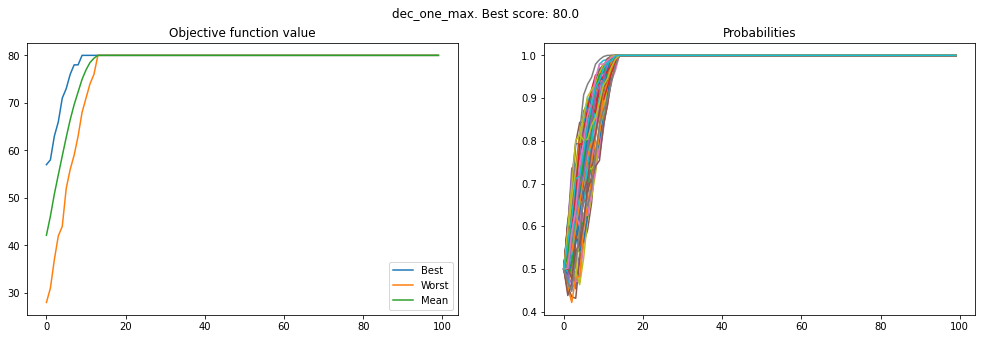

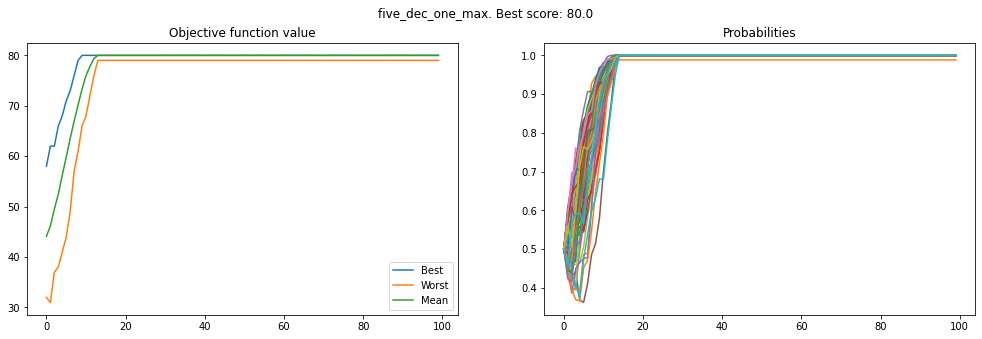

PERCENTILE = 40


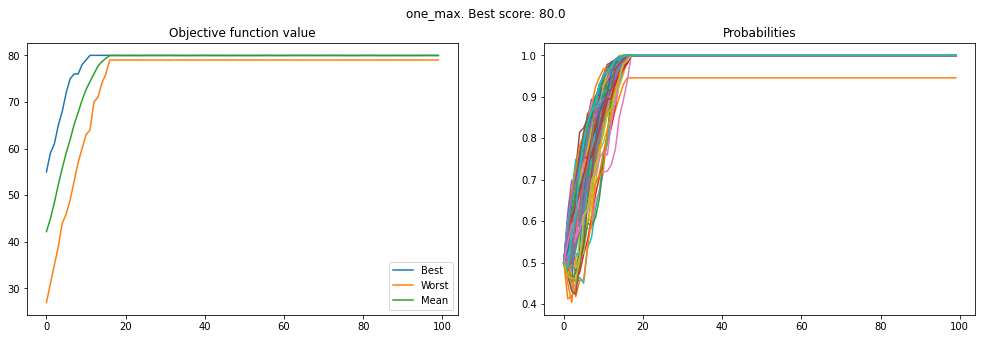

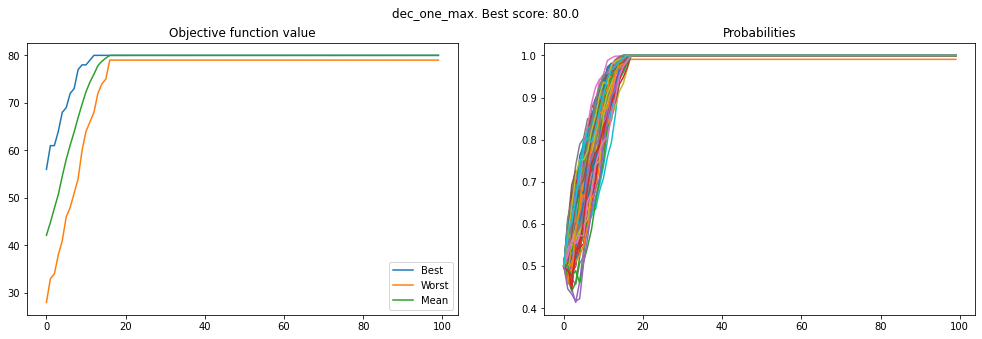

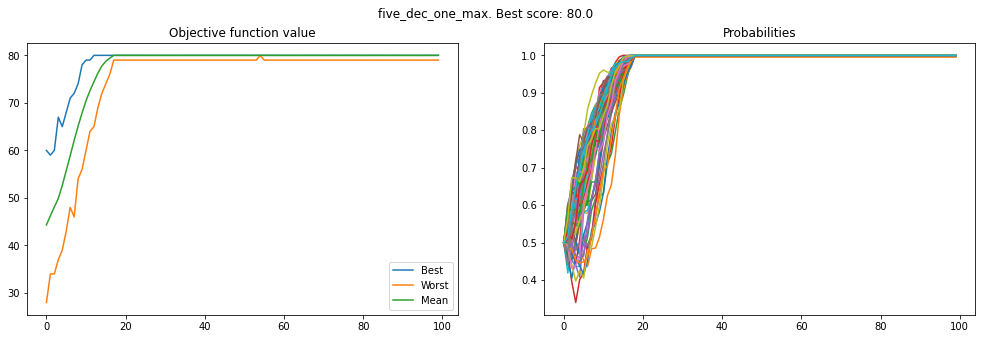

PERCENTILE = 50


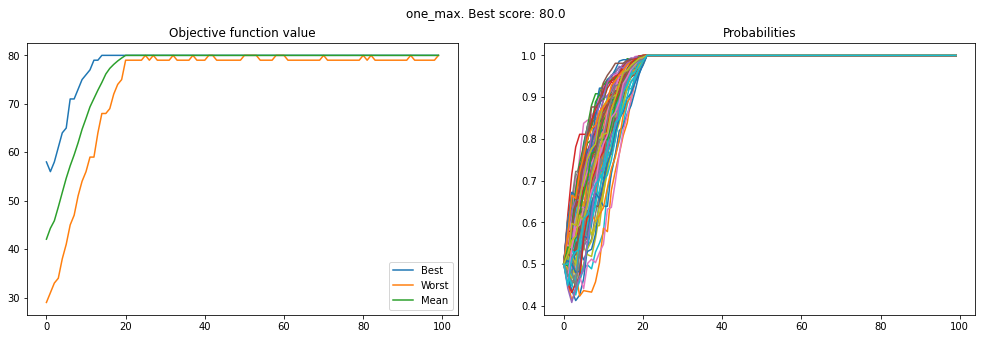

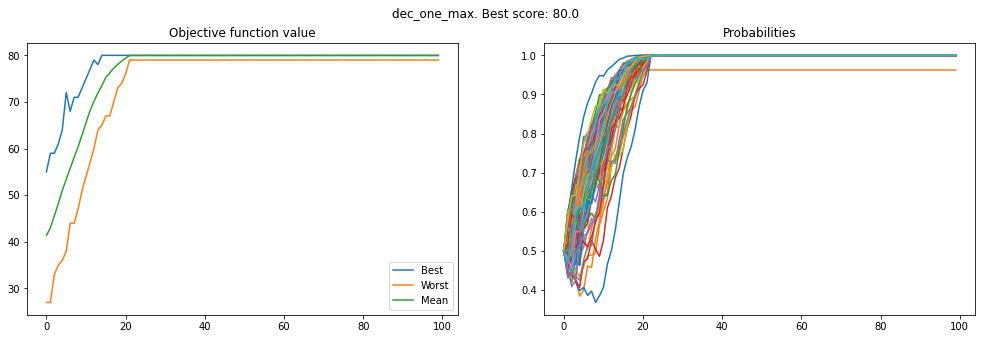

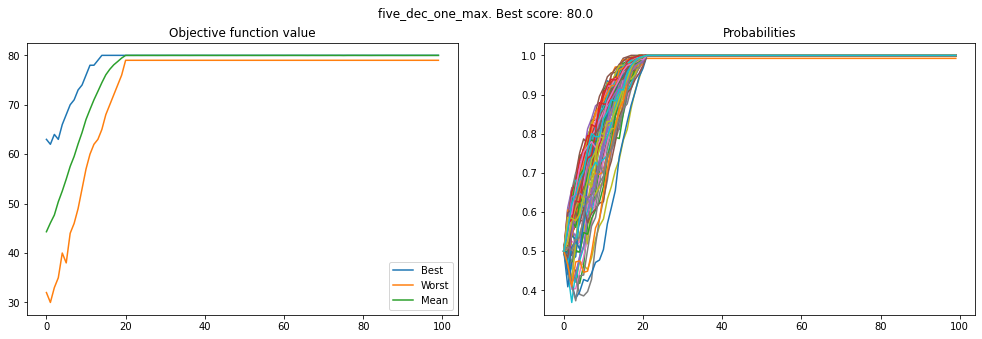

PERCENTILE = 60


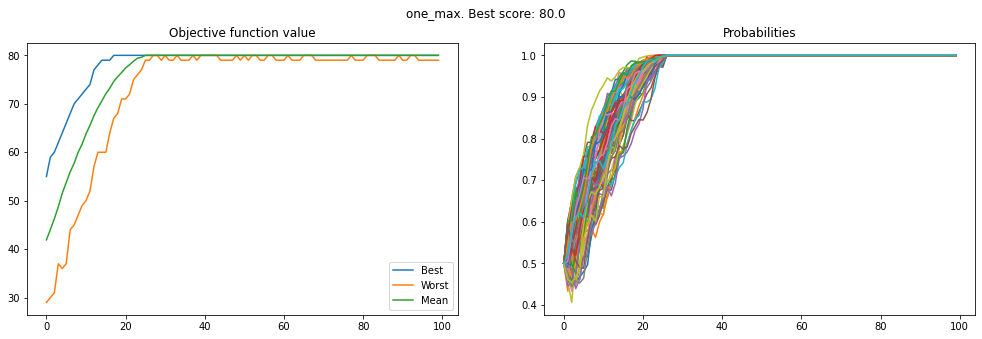

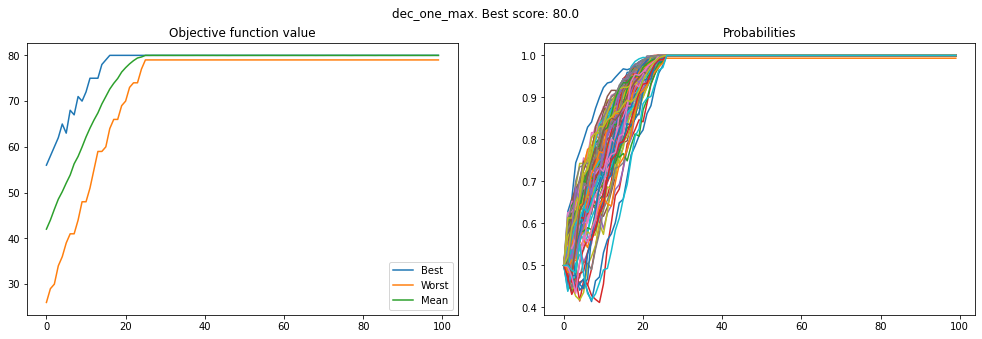

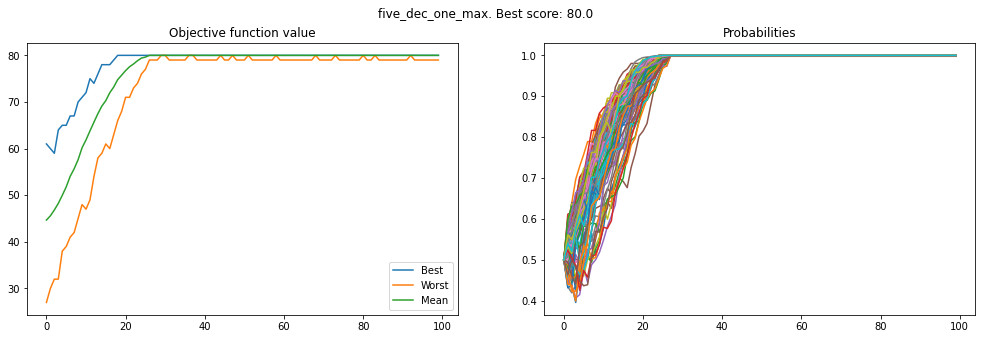

PERCENTILE = 70


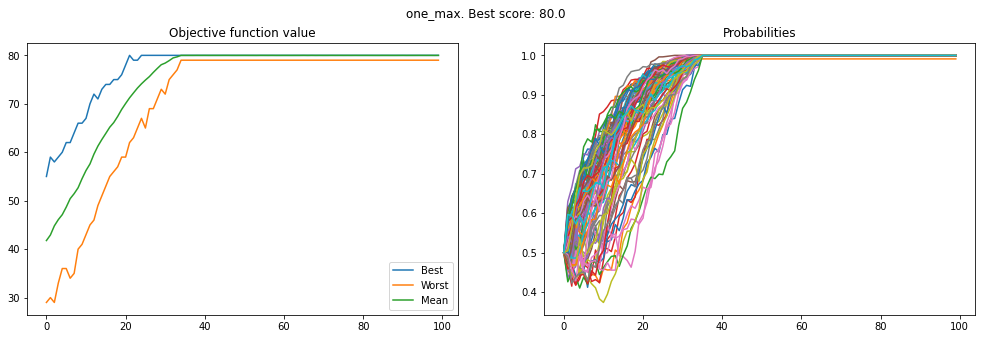

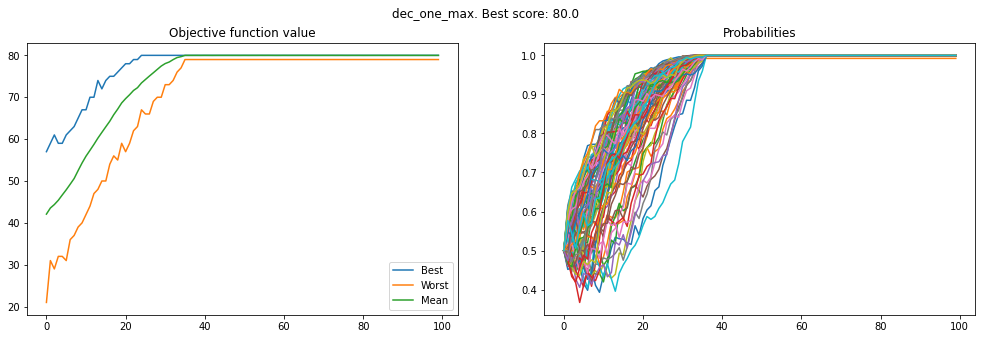

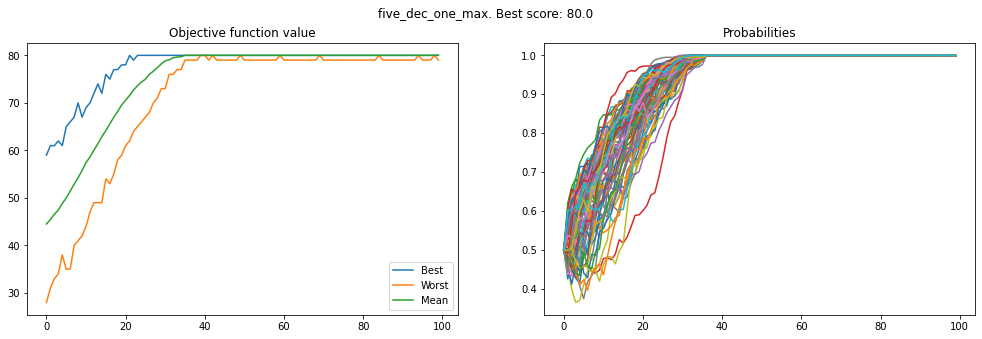

PERCENTILE = 80


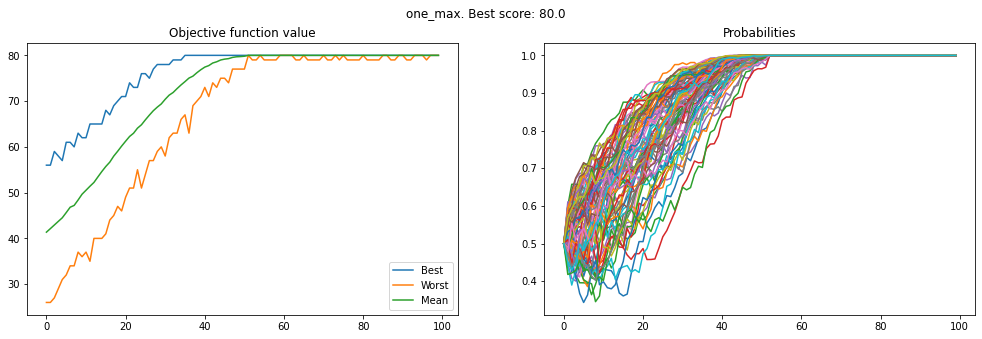

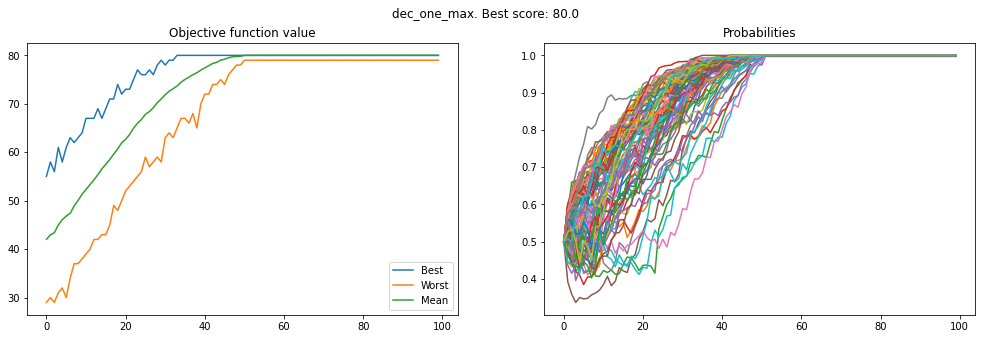

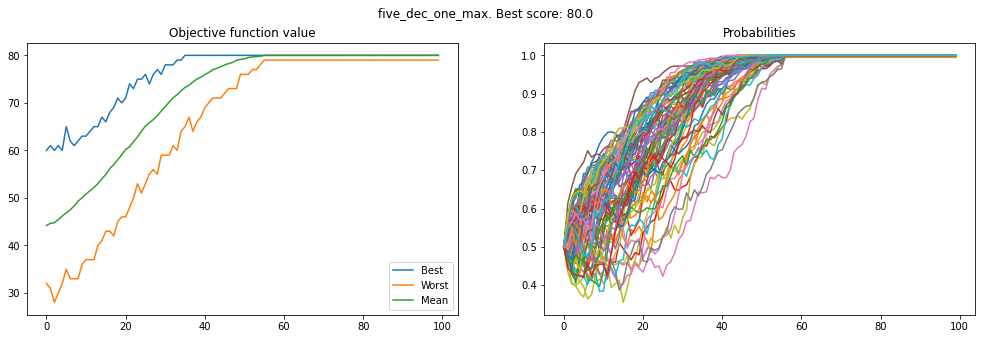

PERCENTILE = 90


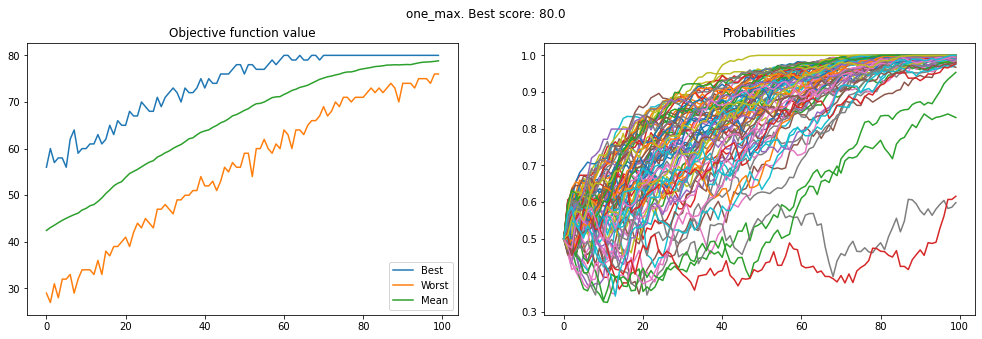

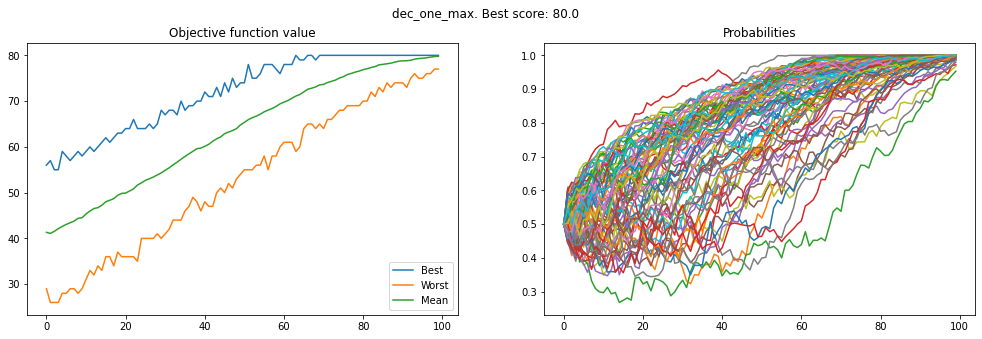

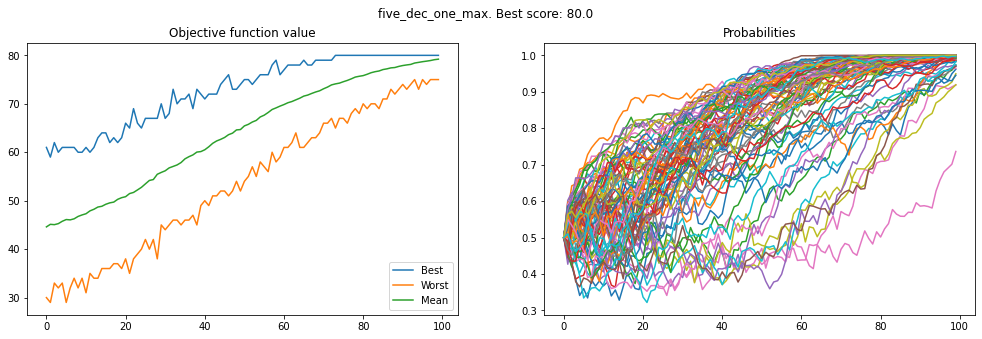

In [71]:
for percentile in np.arange(10, 100, 10):
    print(f"PERCENTILE = {percentile}")
    test_mimic(100, 1000, percentile, _d = 80)

PERCENTILE: 89


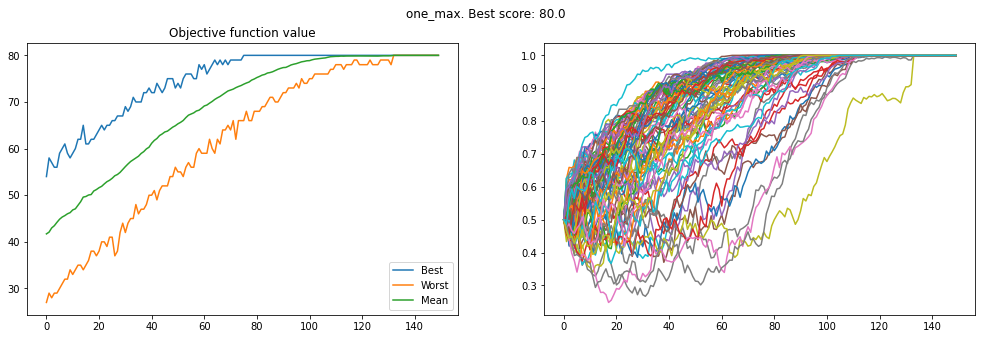

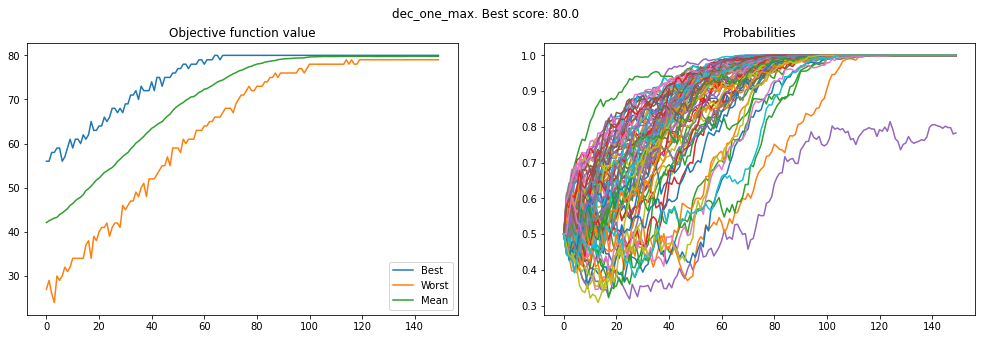

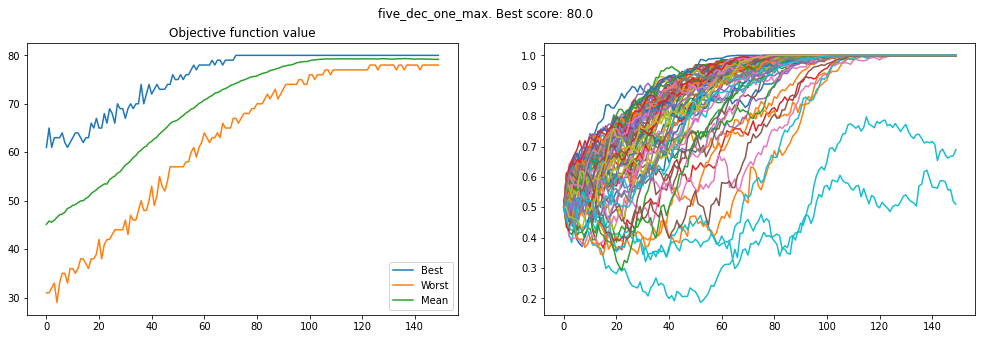

PERCENTILE: 90


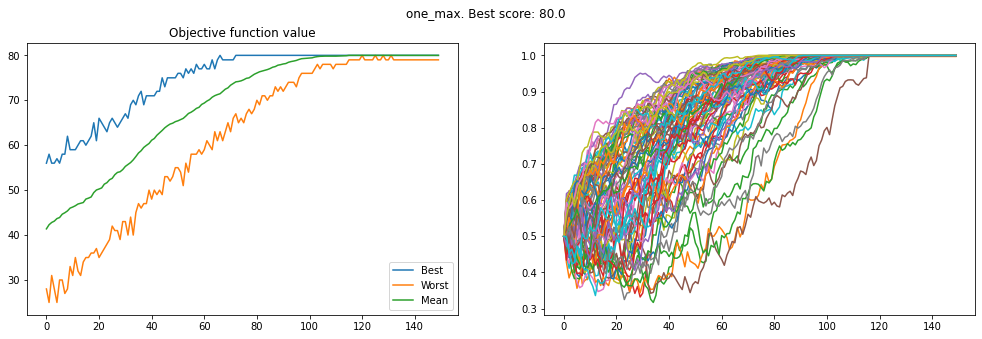

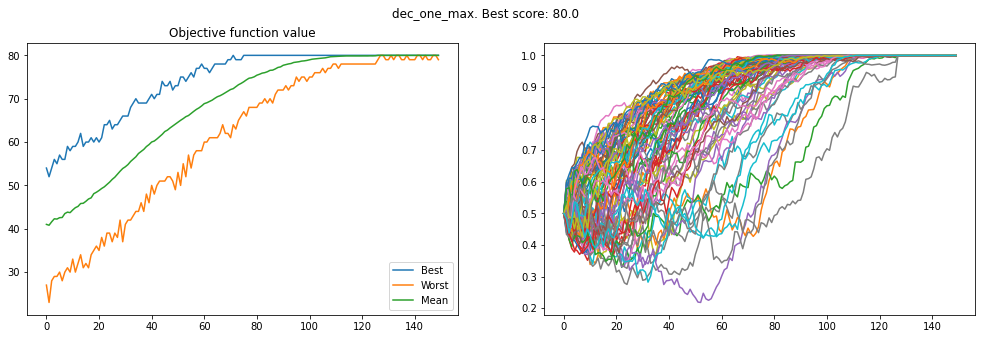

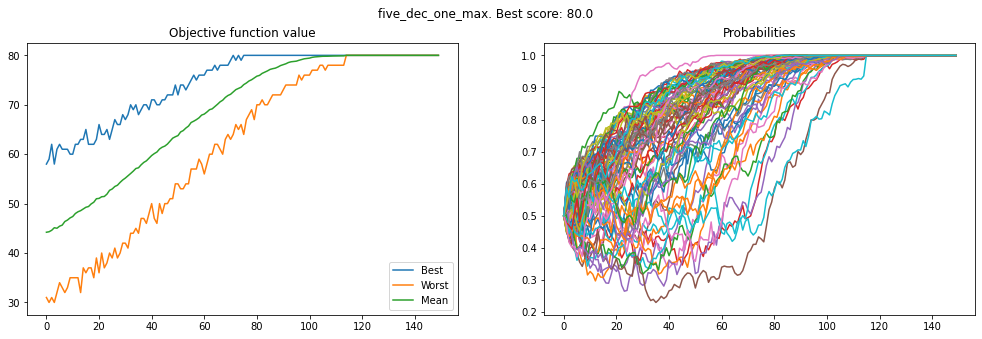

PERCENTILE: 91


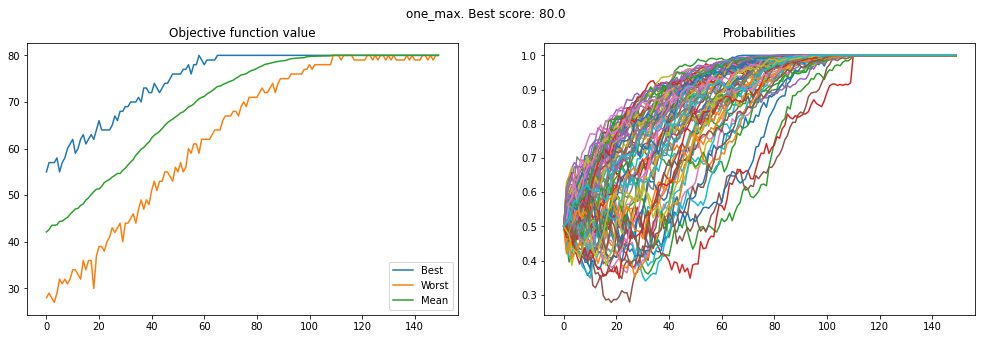

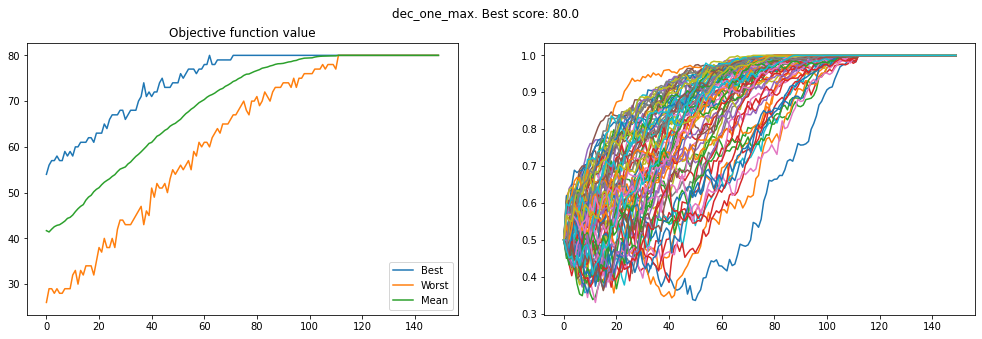

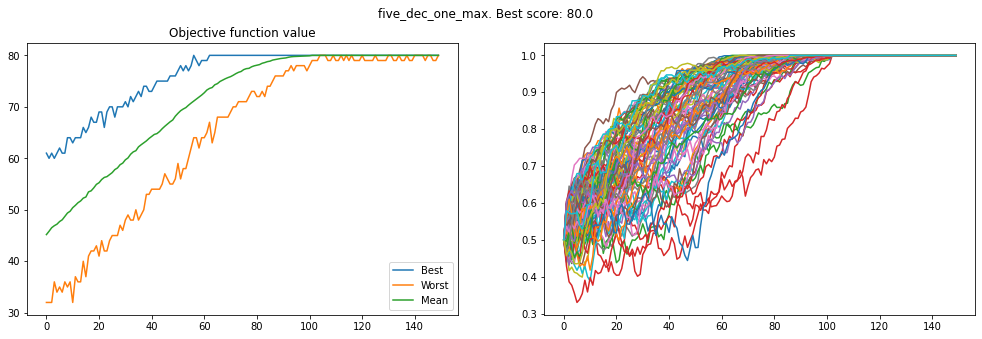

PERCENTILE: 92


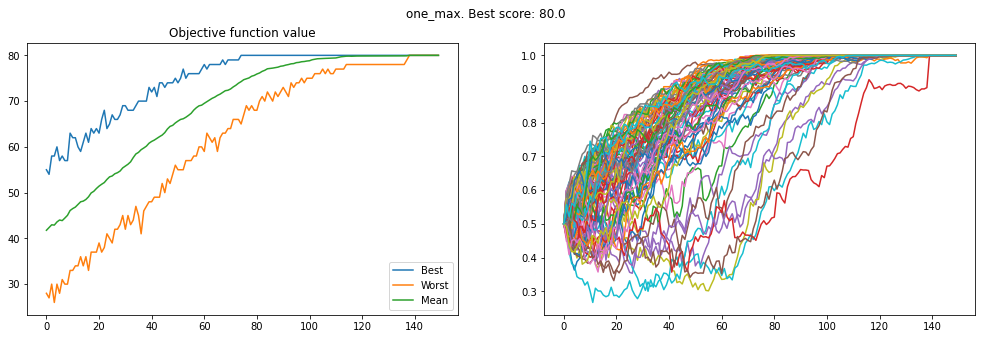

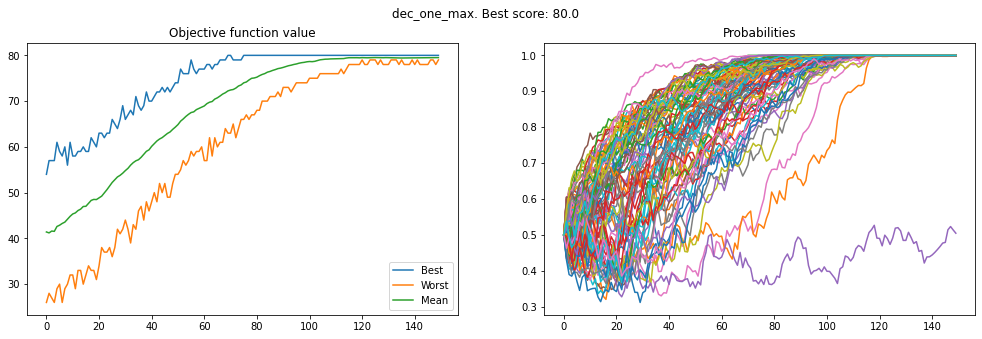

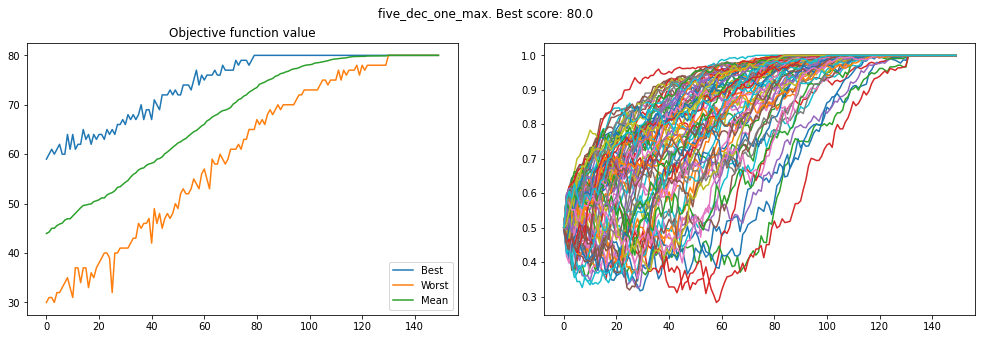

PERCENTILE: 93


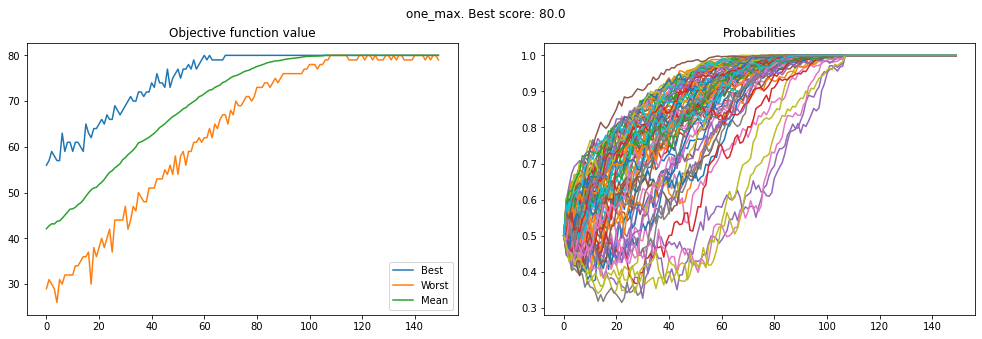

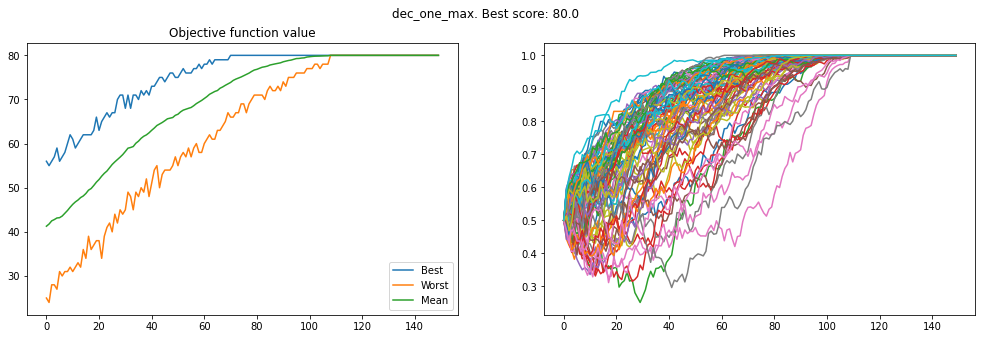

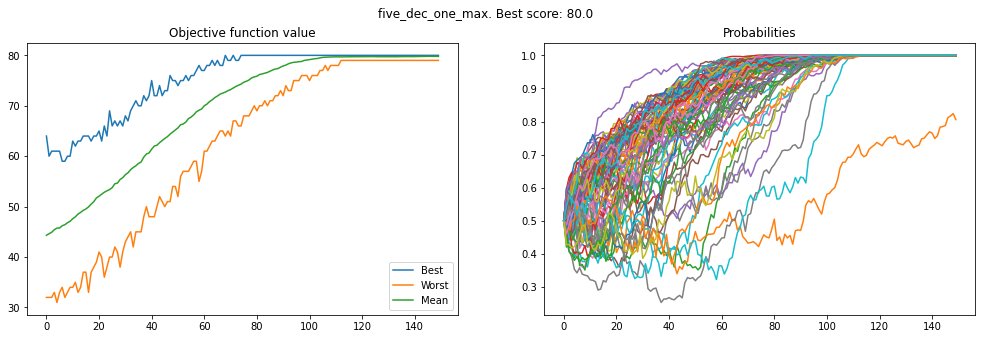

PERCENTILE: 94


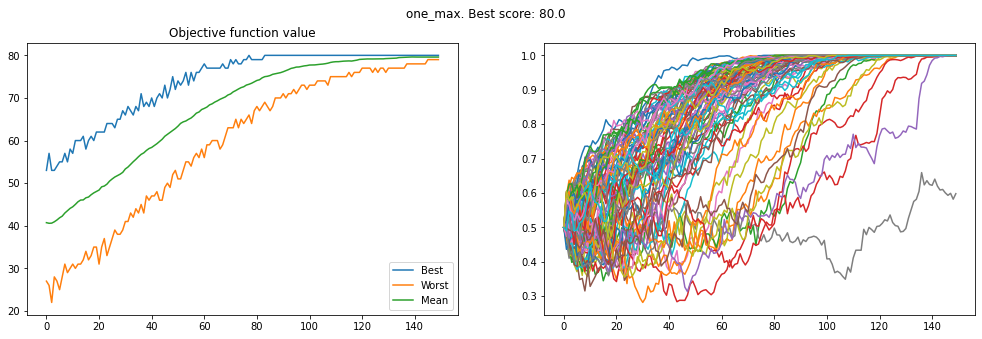

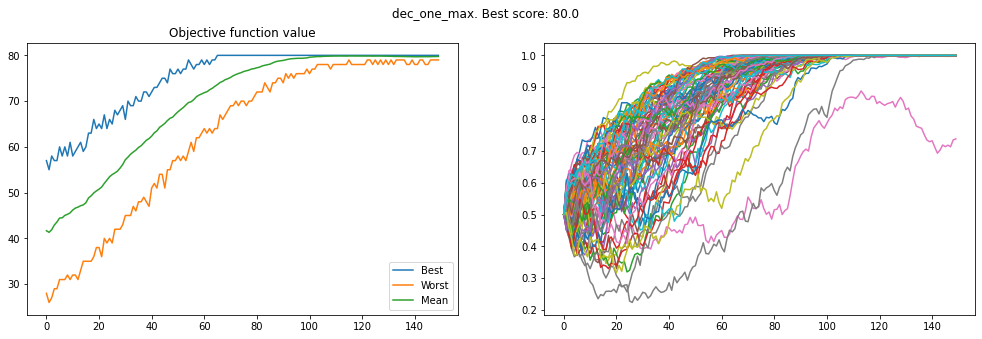

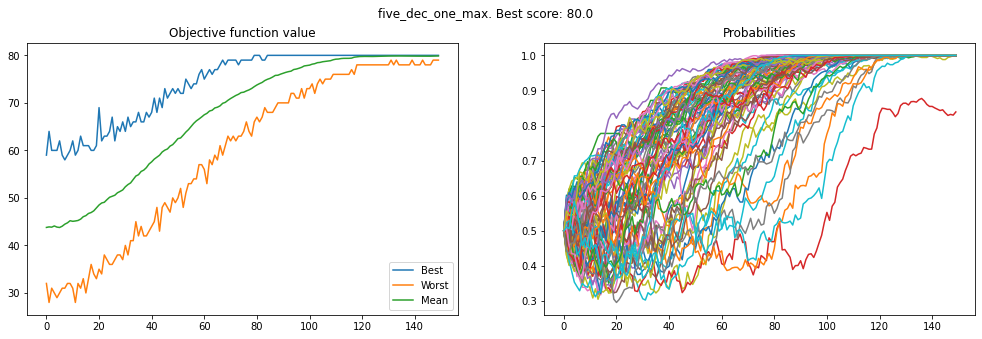

In [72]:
for percentile in [89, 90, 91, 92, 93, 94]:
    print(f"PERCENTILE: {percentile}")
    test_mimic(150, 1000, 90, _d = 80)

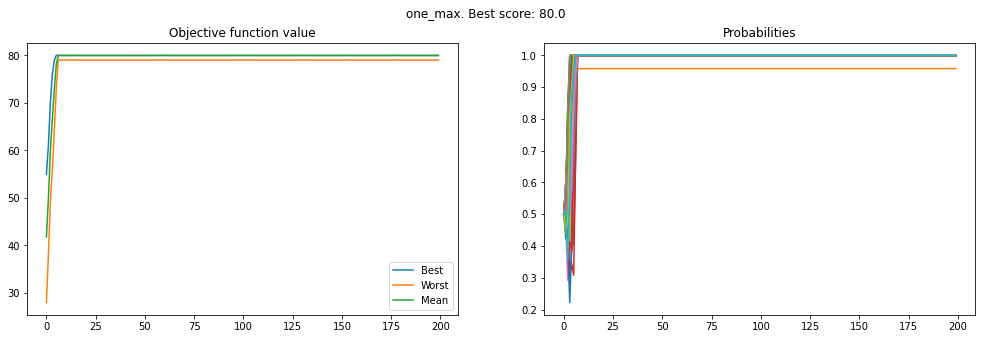

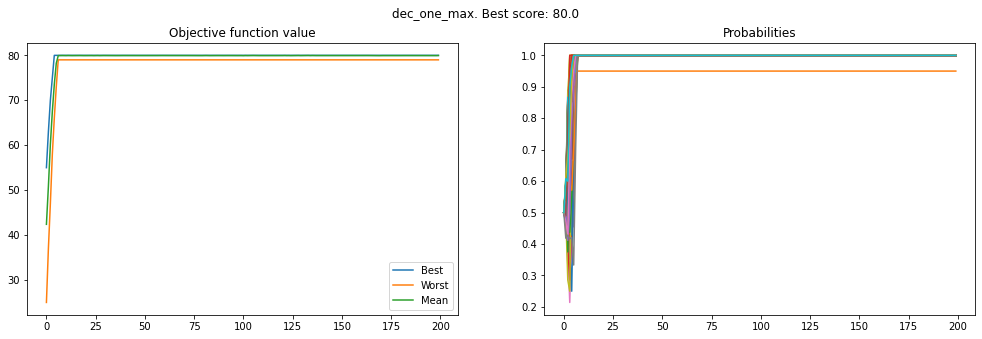

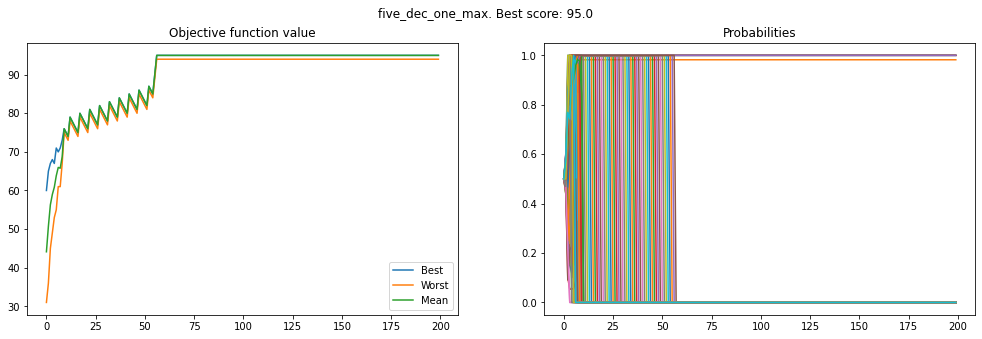

In [75]:
test_mimic(200, 1000, 2, _d = 80)

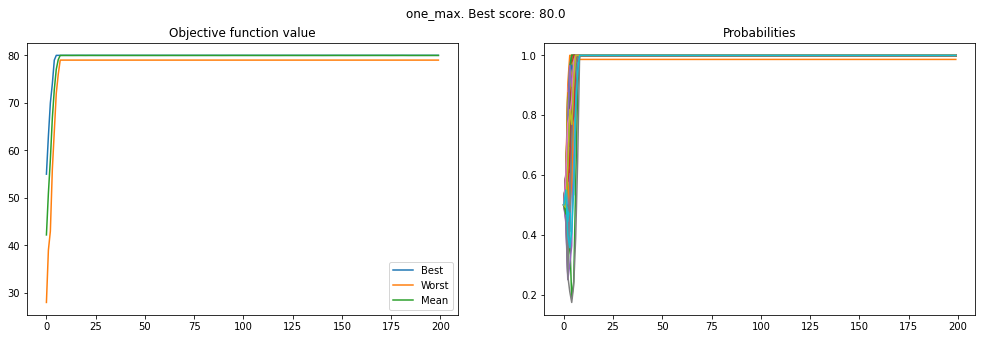

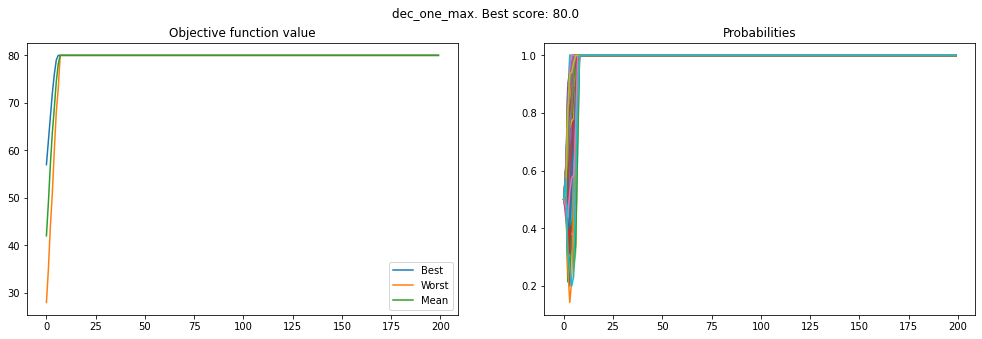

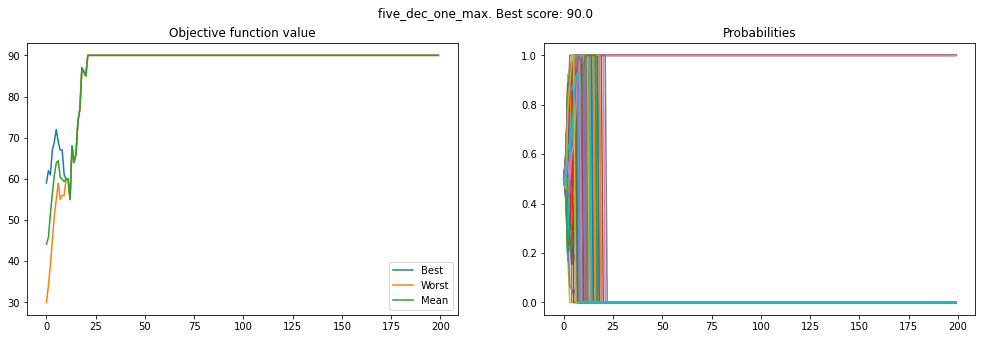

In [80]:
test_mimic(200, 1000, 3, _d = 80)

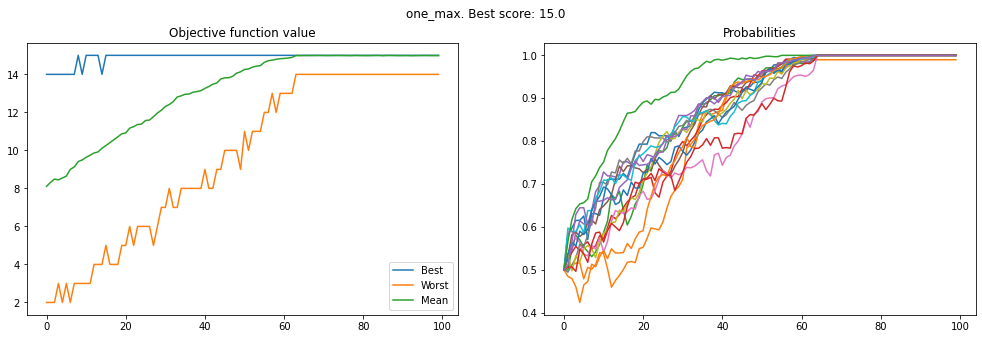

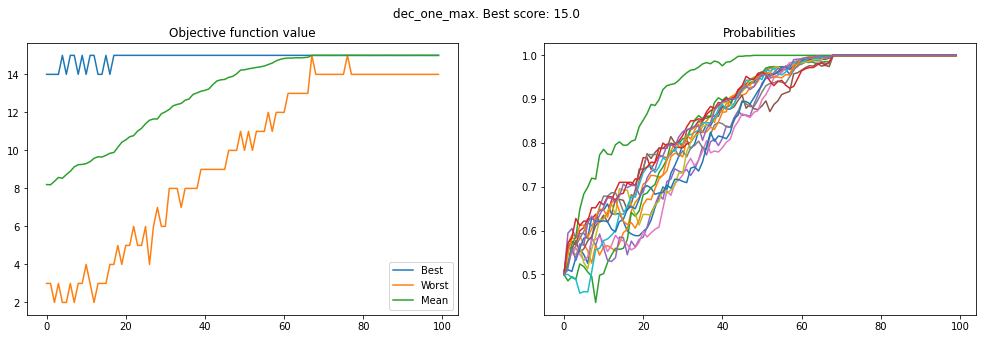

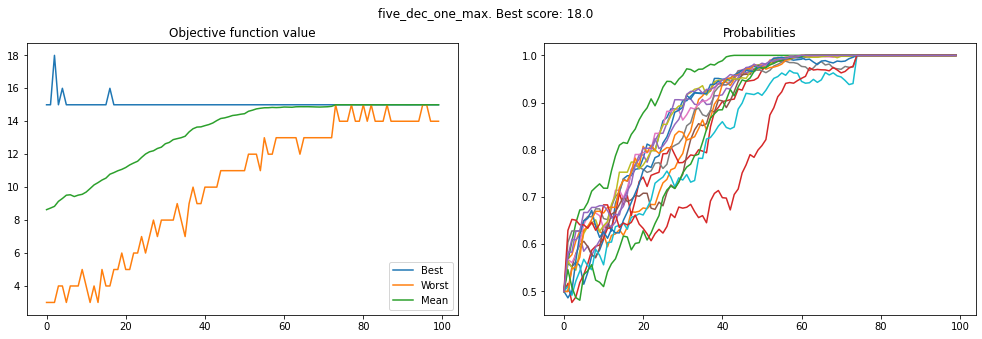

In [67]:
test_mimic(100, 1000, 90, _d = 15)